In [1]:

import os
import time
from PIL import Image
import pandas as pd

import pyspark
import os as os
from pyspark.sql import SparkSession

from sklearn.manifold import TSNE
import time
import seaborn as sns

#customised functions 
def set_up_working_directory(str_dir_path):
    os.chdir(str_dir_path)
    print("Working direcotry changed to " + os.getcwd())

def data_basic_details(image_folder_path): 
    
    df = pd.DataFrame(columns = ['FileName', 'width', 'height'])
    print(df)
    start_time = time.time()
    #iterate through every file
    for r, d, f in os.walk(image_folder_path):
        for file in f:
            if file.endswith(".jpg"):
                width, height = Image.open(os.path.join(r, file)).size
                df = df.append({'FileName' :  file , 'width' :width  , 'height' :height  },ignore_index = True)
    #total time taken 
    print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(time.time() - start_time)))

def spark_spin_up_session(session_name):
    spark = SparkSession.builder.appName(session_name).getOrCreate()
    return spark 

def spark_read_csv(sparkobj, file_path):
    spark = sparkobj
    readobj= spark.read.option('header','true').csv(file_path)
    return readobj

def spark_read_images_from_path(sparkobj, file_path):
    spark = sparkobj
    image_df = spark.read.format("image").load(file_path, inferschema=True)
    return image_df

def spark_return_image_attribute(image_obj):
    image_obj.select("image.origin", "image.width", "image.height","image.nChannels", "image.mode").show(truncate=False)


In [2]:
spark= spark_spin_up_session("session1")
spark

In [3]:
image_df= spark_read_images_from_path(spark, "e:/dev/Kaggle/fashion/sample/1164.jpg")
spark_return_image_attribute(image_df)

+---------------------------------------------+-----+------+---------+----+
|origin                                       |width|height|nChannels|mode|
+---------------------------------------------+-----+------+---------+----+
|file:///e:/dev/Kaggle/fashion/sample/1164.jpg|60   |80    |3        |16  |
+---------------------------------------------+-----+------+---------+----+



In [4]:
image_df = spark_read_images_from_path(spark, "e:/dev/Kaggle/fashion/sample/")
spark_return_image_attribute(image_df)

+---------------------------------------------+-----+------+---------+----+
|origin                                       |width|height|nChannels|mode|
+---------------------------------------------+-----+------+---------+----+
|file:///e:/dev/Kaggle/fashion/sample/1611.jpg|60   |80    |3        |16  |
|file:///e:/dev/Kaggle/fashion/sample/1619.jpg|60   |80    |3        |16  |
|file:///e:/dev/Kaggle/fashion/sample/1755.jpg|60   |80    |3        |16  |
|file:///e:/dev/Kaggle/fashion/sample/1752.jpg|60   |80    |3        |16  |
|file:///e:/dev/Kaggle/fashion/sample/1533.jpg|60   |80    |3        |16  |
|file:///e:/dev/Kaggle/fashion/sample/1689.jpg|60   |80    |3        |16  |
|file:///e:/dev/Kaggle/fashion/sample/1982.jpg|60   |80    |3        |16  |
|file:///e:/dev/Kaggle/fashion/sample/1570.jpg|60   |80    |3        |16  |
|file:///e:/dev/Kaggle/fashion/sample/1531.jpg|60   |80    |3        |16  |
|file:///e:/dev/Kaggle/fashion/sample/1617.jpg|60   |80    |3        |16  |
|file:///e:/

In [5]:
image_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [6]:
display(image_df)

DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>]

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure

In [8]:
DATASET_PATH = "e:/dev/Kaggle/fashion/"
print(os.listdir(DATASET_PATH))

['df_embs.txt', 'embed.txt', 'images', 'myntradataset', 'my_model.h5', 'project', 'sample', 'styles.csv']


In [9]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [10]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return DATASET_PATH+"images/"+img

def load_image(img):
    return cv2.imread(img_path(img))

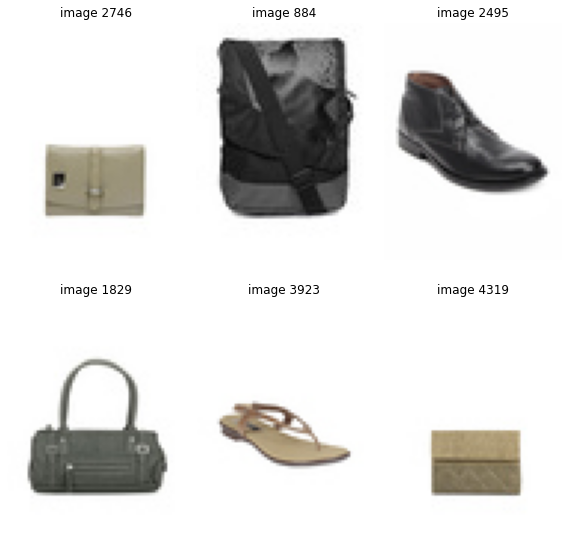

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'image '+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

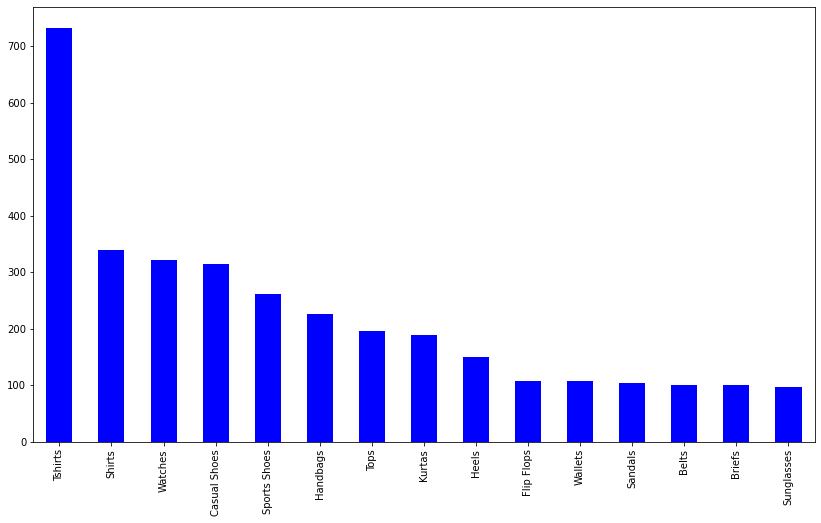

In [46]:
plt.figure(figsize=(14,8))
df.articleType.value_counts().nlargest(15).plot(kind='bar', color="blue")

In [13]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D
tf.__version__

'2.4.0'

In [14]:
# Input Shape
img_width, img_height, _ = load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = tf.keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 2, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [ ]:
def get_embedding(DATASET_PATH, model, img_name, img_width, img_height):
    # Reshape
    img = image.load_img(img_path(DATASET_PATH,img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)


In [16]:
emb = get_embedding(DATASET_PATH, model, df.iloc[1].image)
emb.shape

(2048,)

[1.8793364  1.6008836  0.09203261 ... 3.2688963  2.2717304  5.4333878 ]


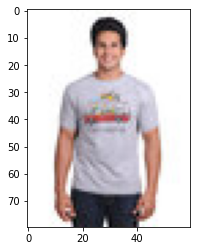

In [29]:
plt.imshow(cv2.cvtColor(load_image(df.iloc[1].image), cv2.COLOR_BGR2RGB))
print(emb)

In [18]:
%%time
import swifter

# Parallel apply
map_embeddings = df['image'].swifter.apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()


(5000, 2048)
Wall time: 7min 56s


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,3.539255,0.000000,1.094599,0.000000,0.000000,4.458534,2.446015,2.678130,0.0,...,0.424307,0.000000,0.000000,5.880399,0.000000,0.000000,6.428889,4.408069,0.950041,1.847197
1,1.879336,1.600884,0.092033,4.433075,0.000000,0.000000,3.030769,8.530592,5.498659,0.0,...,2.808288,0.000000,3.923478,3.183100,0.000000,0.000000,4.244201,3.268896,2.271730,5.433388
2,0.000000,0.311199,0.000000,3.808681,0.437031,7.112498,0.000000,0.000000,0.000000,0.0,...,0.218206,7.861299,1.655931,0.000000,0.000000,0.000000,4.703013,0.000000,2.340579,0.000000
3,0.588018,9.894616,0.000000,6.295309,1.783727,1.913123,0.000000,13.309944,7.805779,0.0,...,22.434368,0.000000,0.000000,0.000000,2.565927,3.330477,0.594361,1.130466,3.084235,7.608929
4,0.000000,1.882976,0.000000,5.122097,0.000000,0.000000,2.950291,6.626864,1.606633,0.0,...,2.504943,0.000000,1.274129,3.484578,0.786350,0.000000,1.597857,2.515498,0.068353,0.000000


In [19]:
# load distance metrics 
from sklearn.metrics.pairwise import pairwise_distances

#find distance metrics 
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[0.99999934, 0.5813052 , 0.23863798, 0.49294078],
       [0.5813052 , 0.99999905, 0.23951322, 0.72273475],
       [0.23863798, 0.23951322, 0.9999998 , 0.22011638],
       [0.49294078, 0.72273475, 0.22011638, 1.        ]], dtype=float32)

In [52]:
indices = pd.Series(range(len(df)), index=df.index)
indices

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, max_rec = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:max_rec+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(2993, df, max_rec = 3)

(Int64Index([259, 4305, 0], dtype='int64'), [0.9040973, 0.8925514, 0.89175576])

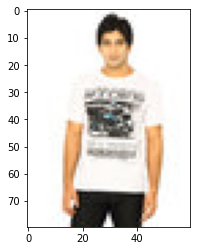

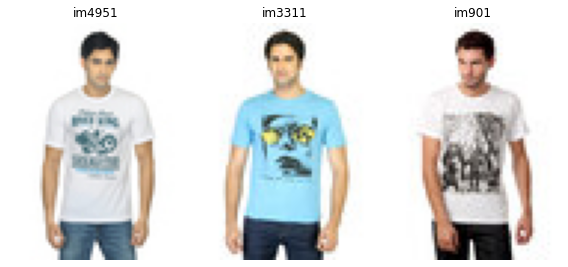

In [53]:
# Idx Item to Recommender
idx_ref = 4100

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, max_rec = 3)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 1, 3)

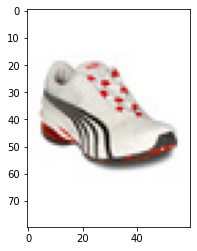

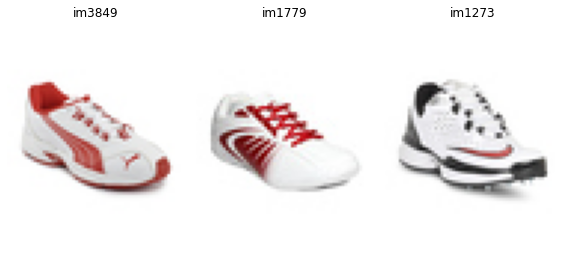

In [54]:
idx_ref = 987

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, max_rec = 3)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 1, 3)

In [25]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 119.30700016021729 seconds


In [26]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

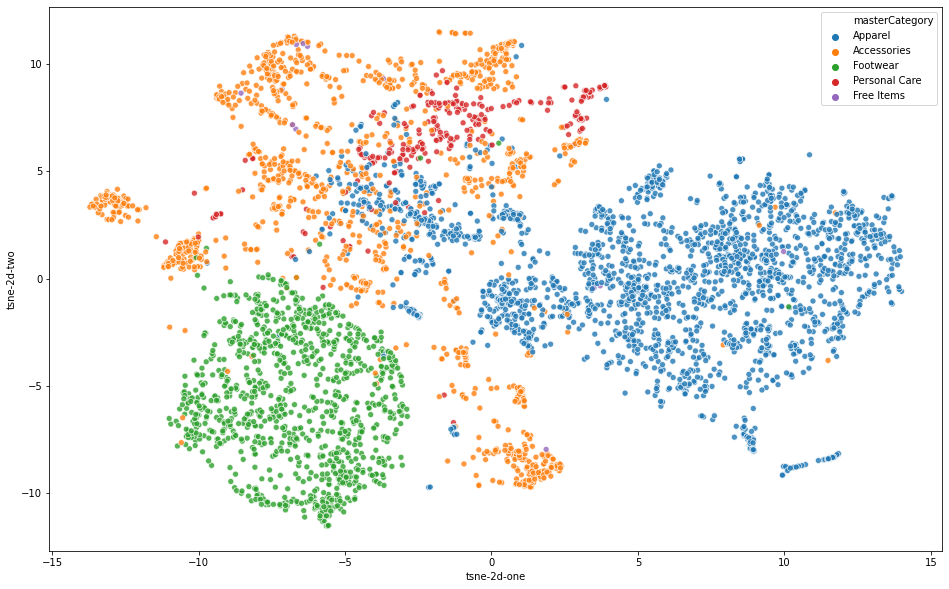

In [27]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

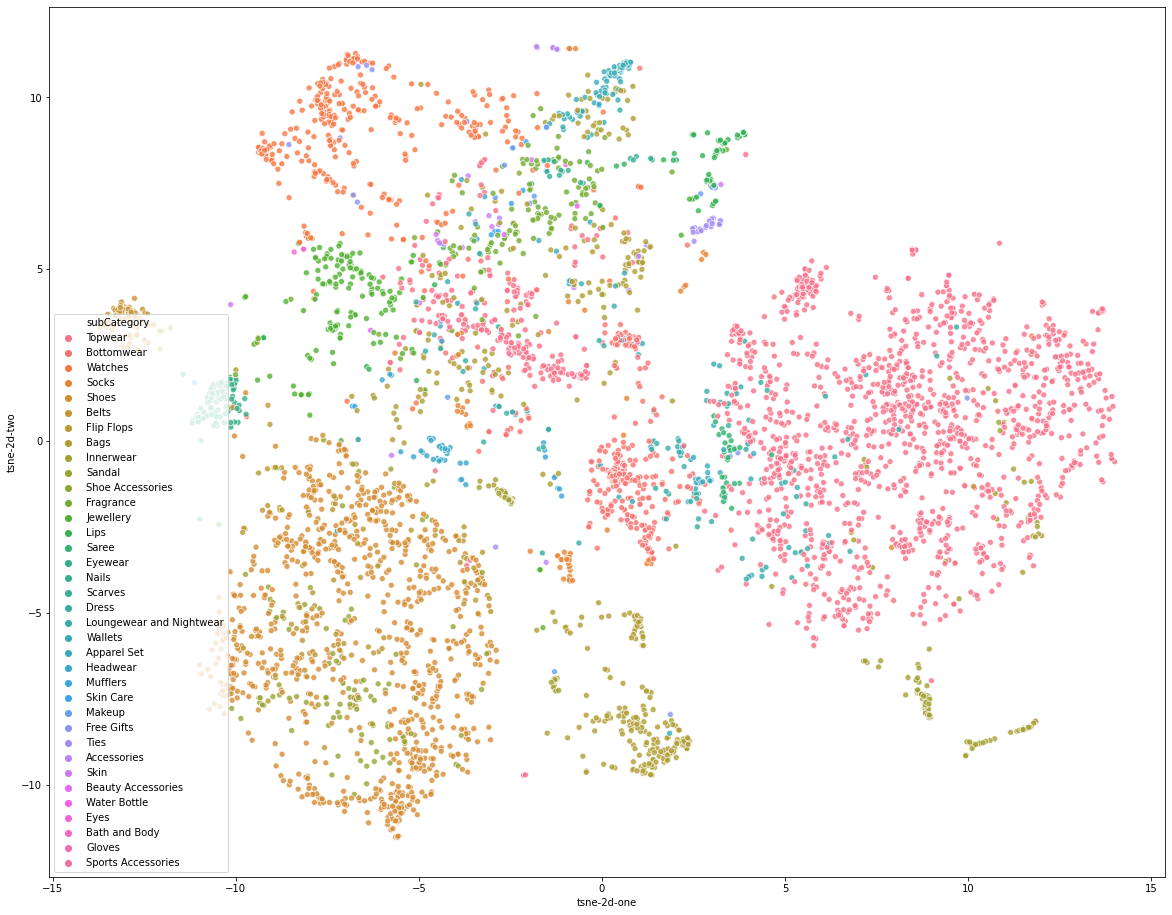

In [28]:
plt.figure(figsize=(20,16))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)